#Requirements

In [16]:
!pip install numpy torch torchvision pytorch-ignite tensorboardX tensorboard opendatasets efficientnet-pytorch

# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import models, datasets
from torchvision import transforms as T

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, Precision, Recall
from ignite.handlers import LRScheduler, ModelCheckpoint, global_step_from_engine
from ignite.contrib.handlers import ProgressBar, TensorboardLogger
import ignite.contrib.engines.common as common

import opendatasets as od
import os
from random import randint
import urllib
import zipfile

# Define device to use (CPU or GPU). CUDA = GPU support for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 M

In [18]:
od.download("https://www.kaggle.com/akash2sharma/tiny-imagenet")
DATA_DIR = 'tiny-imagenet/tiny-imagenet-200'
# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'val')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: prathambhandoria
Your Kaggle Key: ··········


100%|██████████| 474M/474M [00:08<00:00, 58.2MB/s]


In [19]:
directory = 'tiny-imagenet/tiny-imagenet-200'
num_classes = 200

In [20]:
# modify this depending on memory constraints
batch_size = 64

# the magic normalization parameters come from the example
transform_mean = np.array([ 0.485, 0.456, 0.406 ])
transform_std = np.array([ 0.229, 0.224, 0.225 ])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = transform_mean, std = transform_std),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = transform_mean, std = transform_std),
])

traindir = os.path.join(directory, "train")
# be careful with this set, the labels are not defined using the directory structure
valdir = os.path.join(directory, "val")

train = datasets.ImageFolder(traindir, train_transform)
val = datasets.ImageFolder(valdir, val_transform)

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

assert num_classes == len(train_loader.dataset.classes)

In [24]:
small_labels = {}
with open(os.path.join(directory, "words.txt"), "r") as dictionary_file:
    line = dictionary_file.readline()
    while line:
        label_id, label = line.strip().split("\t")
        small_labels[label_id] = label
        line = dictionary_file.readline()

In [27]:

list(small_labels.items())[:5]


[('n00001740', 'entity'),
 ('n00001930', 'physical entity'),
 ('n00002137', 'abstraction, abstract entity'),
 ('n00002452', 'thing'),
 ('n00002684', 'object, physical object')]

In [28]:
os.listdir(traindir)[:5]


['n02769748', 'n03662601', 'n04371430', 'n04275548', 'n02132136']

In [29]:
labels = {}
label_ids = {}
for label_index, label_id in enumerate(train_loader.dataset.classes):
    label = small_labels[label_id]
    labels[label_index] = label
    label_ids[label_id] = label_index

In [31]:
list(small_labels.items())[:5]


[('n00001740', 'entity'),
 ('n00001930', 'physical entity'),
 ('n00002137', 'abstraction, abstract entity'),
 ('n00002452', 'thing'),
 ('n00002684', 'object, physical object')]

In [34]:
list(label_ids.items())[:5]


[('n01443537', 0),
 ('n01629819', 1),
 ('n01641577', 2),
 ('n01644900', 3),
 ('n01698640', 4)]

In [35]:
val_label_map = {}
with open(os.path.join(directory, "val/val_annotations.txt"), "r") as val_label_file:
    line = val_label_file.readline()
    while line:
        file_name, label_id, _, _, _, _ = line.strip().split("\t")
        val_label_map[file_name] = label_id
        line = val_label_file.readline()

In [37]:
list(val_label_map.items())[:5]


[('val_0.JPEG', 'n03444034'),
 ('val_1.JPEG', 'n04067472'),
 ('val_2.JPEG', 'n04070727'),
 ('val_3.JPEG', 'n02808440'),
 ('val_4.JPEG', 'n02808440')]

In [38]:
val_loader.dataset.imgs[:5]


[('tiny-imagenet/tiny-imagenet-200/val/images/val_0.JPEG', 0),
 ('tiny-imagenet/tiny-imagenet-200/val/images/val_1.JPEG', 0),
 ('tiny-imagenet/tiny-imagenet-200/val/images/val_10.JPEG', 0),
 ('tiny-imagenet/tiny-imagenet-200/val/images/val_100.JPEG', 0),
 ('tiny-imagenet/tiny-imagenet-200/val/images/val_1000.JPEG', 0)]

In [39]:
for i in range(len(val_loader.dataset.imgs)):
    file_path = val_loader.dataset.imgs[i][0]

    file_name = os.path.basename(file_path)
    label_id = val_label_map[file_name]

    val_loader.dataset.imgs[i] = (file_path, label_ids[label_id])

In [40]:
val_loader.dataset.imgs[:5]


[('tiny-imagenet/tiny-imagenet-200/val/images/val_0.JPEG', 107),
 ('tiny-imagenet/tiny-imagenet-200/val/images/val_1.JPEG', 139),
 ('tiny-imagenet/tiny-imagenet-200/val/images/val_10.JPEG', 158),
 ('tiny-imagenet/tiny-imagenet-200/val/images/val_100.JPEG', 90),
 ('tiny-imagenet/tiny-imagenet-200/val/images/val_1000.JPEG', 138)]

# Baseline model

In [41]:
def initialize_weights(m):
    weight_shape = list(m.weight.data.size())
    fan_in = weight_shape[1]
    fan_out = weight_shape[0]
    w_bound = np.sqrt(6. / (fan_in + fan_out))
    m.weight.data.uniform_(-w_bound, w_bound)
    m.bias.data.fill_(0)

In [44]:
pre_trained_model = models.alexnet(pretrained=True)
state_dict = pre_trained_model.state_dict()
state_dict.pop("classifier.6.weight")
state_dict.pop("classifier.6.bias")
model = models.alexnet(num_classes=num_classes)
model.load_state_dict(state_dict, strict=False)

parameters = model.classifier[6].parameters()
initialize_weights(model.classifier[6])


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=0.001, momentum=0.9) #adams optimizer
def top_k_error(top_k, total):
    return 100.0 - top_k / total * 100.0

In [51]:
def run_epoch(loader, train=True, log_every=100):
    running_loss = 0.0
    running_top_1 = 0.0
    running_top_5 = 0.0
    running_total = 0.0

    epoch_top_1 = 0.0
    epoch_top_5 = 0.0
    epoch_total = 0.0

    model.train(mode=train)

    for batch_number, (batch_inputs, batch_labels) in enumerate(loader):
        batch_inputs, batch_labels = Variable(batch_inputs), Variable(batch_labels)

        if train:
            optimizer.zero_grad()

        batch_logits = model(batch_inputs)

        if train:
            batch_loss = criterion(batch_logits, batch_labels)
            batch_loss.backward()

            optimizer.step()

            running_loss += batch_loss.item()


        batch_labels = batch_labels.data.cpu().numpy()
        batch_predictions = batch_logits.topk(5)[1].data.cpu().numpy()

        for i in range(len(batch_labels)):
            if batch_labels[i] == batch_predictions[i, 0]:
                running_top_1 += 1
                running_top_5 += 1
                epoch_top_1 += 1
                epoch_top_5 += 1
            else:
                for j in range(1, 5):
                    if batch_labels[i] == batch_predictions[i, j]:
                        running_top_5 += 1
                        epoch_top_5 += 1
                        break

        running_total += len(batch_labels)
        epoch_total += len(batch_labels)

        if batch_number % log_every == log_every - 1:
            if train:
                print("[Batch {:5d}] Loss: {:.3f} Top-1 Error: {:.3f} Top-5 Error: {:.3f}".format(
                    batch_number + 1,
                    running_loss / log_every,
                    top_k_error(running_top_1, running_total),
                    top_k_error(running_top_5, running_total)
                ))

            running_loss = 0.0
            running_top_1 = 0.0
            running_top_5 = 0.0
            running_total = 0.0

    return top_k_error(epoch_top_1, epoch_total), top_k_error(epoch_top_5, epoch_total)

In [52]:
num_epochs = 1 # modify this to run different number of epochs

for epoch_number in range(num_epochs):

    train_top_1_error, train_top_5_error = run_epoch(train_loader, train=True)
    print("[Epoch {:3d}] Training Top-1 Error: {:.3f} Top-5 Error: {:.3f}".format(
        epoch_number + 1, train_top_1_error, train_top_5_error))

    val_top_1_error, val_top_5_error = run_epoch(val_loader, train=False)
    print("[Epoch {:3d}] Validation Top-1 Error: {:.3f} Top-5 Error: {:.3f}".format(
        epoch_number + 1, val_top_1_error, val_top_5_error))

print("Finished Training")

[Batch   100] Loss: 5.509 Top-1 Error: 97.594 Top-5 Error: 91.219
[Batch   200] Loss: 4.553 Top-1 Error: 89.812 Top-5 Error: 75.375
[Batch   300] Loss: 4.146 Top-1 Error: 85.625 Top-5 Error: 66.250
[Batch   400] Loss: 3.861 Top-1 Error: 81.750 Top-5 Error: 60.328
[Batch   500] Loss: 3.677 Top-1 Error: 79.547 Top-5 Error: 55.594
[Batch   600] Loss: 3.579 Top-1 Error: 76.781 Top-5 Error: 53.656
[Batch   700] Loss: 3.536 Top-1 Error: 76.266 Top-5 Error: 53.094
[Batch   800] Loss: 3.439 Top-1 Error: 75.812 Top-5 Error: 51.375


KeyboardInterrupt: 

So the accuracy we are getting here in the 8 th batch is :
For Top 1 base line is = 24.188 and for Top 5 is = 48.625.
due to very less computation power i am stopping at batch 8. accuracy could have been higher if we go with more no. of batches lets say 20 .

<ipython-input-57-ec654b2d3752>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch_inputs = Variable(batch_inputs, volatile=True)


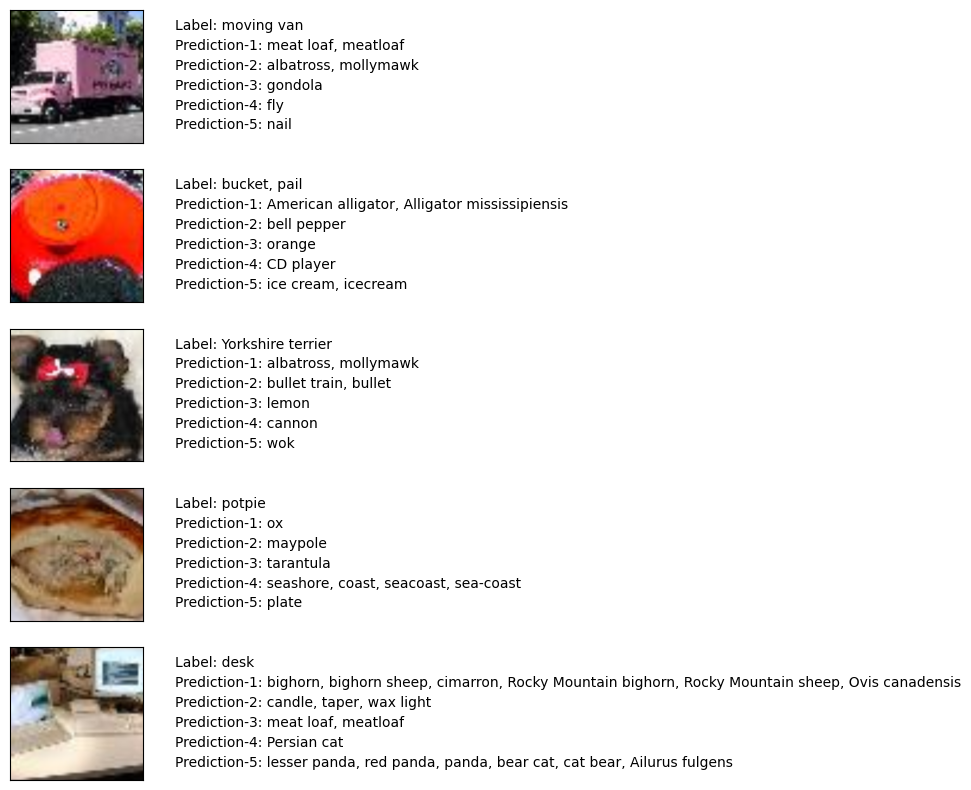

In [57]:
model.train(mode=False)

num_images = 5 # modify the number of images shown

batch_inputs, batch_labels = next(iter(val_loader))
batch_inputs = Variable(batch_inputs, volatile=True)

batch_logits = model(batch_inputs)

batch_labels = batch_labels.numpy()
batch_predictions = batch_logits.topk(5)[1].data.cpu().numpy()

cell_number = 1

plt.figure(figsize=(4, num_images * 2))

for image_number in range(num_images):
    image = np.copy(batch_inputs.data[image_number].cpu().numpy())
    image = np.transpose(image, (1, 2, 0))
    for channel in range(3):
        image[:, :, channel] = image[:, :, channel] * transform_std[channel] + transform_mean[channel]

    label = labels[batch_labels[image_number]]

    plt.subplot(num_images, 2, cell_number)

    ax = plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    cell_number += 1

    plt.subplot(num_images, 2, cell_number)
    plt.axis("off")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.text(0, 0.85, "Label: {}".format(label))
    for prediction_number in range(5):
        plt.text(0, 0.85 - 0.15 * (prediction_number + 1), "Prediction-{:d}: {}".format(
            prediction_number + 1, labels[batch_predictions[image_number, prediction_number]]))

    cell_number += 1

plt.show()

# spectral reg with optimal weight  = 20,000 and weight decay = 0.0001

In [63]:
from transformers import AdamW
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Define your model and load pre-trained weights
pre_trained_model = models.alexnet(pretrained=True)
state_dict = pre_trained_model.state_dict()
state_dict.pop("classifier.6.weight")
state_dict.pop("classifier.6.bias")
model = models.alexnet(num_classes=num_classes)
model.load_state_dict(state_dict, strict=False)

# Initialize the optimizer with the entire model parameters
optimizer = AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.0001)

# Define your loss function
criterion = nn.CrossEntropyLoss()

def top_k_error(top_k, total):
    return 100.0 - top_k / total * 100.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [64]:
import torch
from torch.autograd import Variable

def run_epoch(loader, model, criterion, optimizer=None, train=True, log_every=100, spectral_weight=20000):
    running_loss = 0.0
    running_top_1 = 0.0
    running_top_5 = 0.0
    running_total = 0.0

    epoch_top_1 = 0.0
    epoch_top_5 = 0.0
    epoch_total = 0.0

    model.train(mode=train)

    for batch_number, (batch_inputs, batch_labels) in enumerate(loader):
        batch_inputs, batch_labels = Variable(batch_inputs), Variable(batch_labels)

        if train:
            optimizer.zero_grad()

        batch_logits = model(batch_inputs)

        if train:
            batch_loss = criterion(batch_logits, batch_labels)

            # Spectral Regularization
            weight_sum = 0.0
            for name, param in model.named_parameters():
                if 'weight' in name:
                    weight_sum += torch.sum(param ** 2)
            batch_loss += spectral_weight * weight_sum

            batch_loss.backward()

            optimizer.step()

            running_loss += batch_loss.item()


        batch_labels = batch_labels.data.cpu().numpy()
        batch_predictions = batch_logits.topk(5)[1].data.cpu().numpy()

        for i in range(len(batch_labels)):
            if batch_labels[i] == batch_predictions[i, 0]:
                running_top_1 += 1
                running_top_5 += 1
                epoch_top_1 += 1
                epoch_top_5 += 1
            else:
                for j in range(1, 5):
                    if batch_labels[i] == batch_predictions[i, j]:
                        running_top_5 += 1
                        epoch_top_5 += 1
                        break

        running_total += len(batch_labels)
        epoch_total += len(batch_labels)

        if batch_number % log_every == log_every - 1:
            if train:
                print("[Batch {:5d}] Loss: {:.3f} Top-1 Error: {:.3f} Top-5 Error: {:.3f}".format(
                    batch_number + 1,
                    running_loss / log_every,
                    top_k_error(running_top_1, running_total),
                    top_k_error(running_top_5, running_total)
                ))

            running_loss = 0.0
            running_top_1 = 0.0
            running_top_5 = 0.0
            running_total = 0.0

    return top_k_error(epoch_top_1, epoch_total), top_k_error(epoch_top_5, epoch_total)


In [ ]:
num_epochs = 1 # modify this to run different number of epochs

for epoch_number in range(num_epochs):
    train_top_1_error, train_top_5_error = run_epoch(train_loader, model, criterion, optimizer, train=True)
    print("[Epoch {:3d}] Training Top-1 Error: {:.3f} Top-5 Error: {:.3f}".format(
        epoch_number + 1, train_top_1_error, train_top_5_error))

    val_top_1_error, val_top_5_error = run_epoch(val_loader, model, criterion, train=False)
    print("[Epoch {:3d}] Validation Top-1 Error: {:.3f} Top-5 Error: {:.3f}".format(
        epoch_number + 1, val_top_1_error, val_top_5_error))

print("Finished Training")


[Batch   100] Loss: 25958195.895 Top-1 Error: 99.281 Top-5 Error: 97.359
[Batch   200] Loss: 3554884.880 Top-1 Error: 99.562 Top-5 Error: 97.531
[Batch   300] Loss: 1504967.937 Top-1 Error: 99.578 Top-5 Error: 97.906
[Batch   400] Loss: 759296.054 Top-1 Error: 99.453 Top-5 Error: 97.688
[Batch   500] Loss: 426980.643 Top-1 Error: 99.688 Top-5 Error: 97.844
